In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))

def get_index(tp):
    if len(tp) == 1:
        return all_types.index(tp[0]), len(all_types)
    return all_types.index(tp[0]), all_types.index(tp[1])

types = torch.tensor([get_index(t) for t in types], device=device)

contour = load_contour().to(device)
contour.shape

torch.Size([3, 386, 1, 64, 64])

In [2]:
T = 500
beta = torch.linspace(0.004, 0.03, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0002, device='cuda:0')

In [3]:
alpha_

tensor([9.9600e-01, 9.9196e-01, 9.8789e-01, 9.8379e-01, 9.7965e-01, 9.7547e-01,
        9.7127e-01, 9.6703e-01, 9.6276e-01, 9.5845e-01, 9.5412e-01, 9.4976e-01,
        9.4536e-01, 9.4094e-01, 9.3649e-01, 9.3201e-01, 9.2751e-01, 9.2298e-01,
        9.1842e-01, 9.1384e-01, 9.0923e-01, 9.0460e-01, 8.9994e-01, 8.9526e-01,
        8.9056e-01, 8.8584e-01, 8.8110e-01, 8.7633e-01, 8.7155e-01, 8.6675e-01,
        8.6192e-01, 8.5708e-01, 8.5223e-01, 8.4735e-01, 8.4246e-01, 8.3756e-01,
        8.3264e-01, 8.2770e-01, 8.2275e-01, 8.1779e-01, 8.1281e-01, 8.0782e-01,
        8.0282e-01, 7.9781e-01, 7.9279e-01, 7.8776e-01, 7.8273e-01, 7.7768e-01,
        7.7262e-01, 7.6756e-01, 7.6249e-01, 7.5741e-01, 7.5233e-01, 7.4724e-01,
        7.4215e-01, 7.3706e-01, 7.3196e-01, 7.2686e-01, 7.2175e-01, 7.1665e-01,
        7.1154e-01, 7.0643e-01, 7.0132e-01, 6.9622e-01, 6.9111e-01, 6.8601e-01,
        6.8090e-01, 6.7580e-01, 6.7070e-01, 6.6561e-01, 6.6052e-01, 6.5543e-01,
        6.5035e-01, 6.4528e-01, 6.4021e-

torch.Size([4, 3, 72, 72])


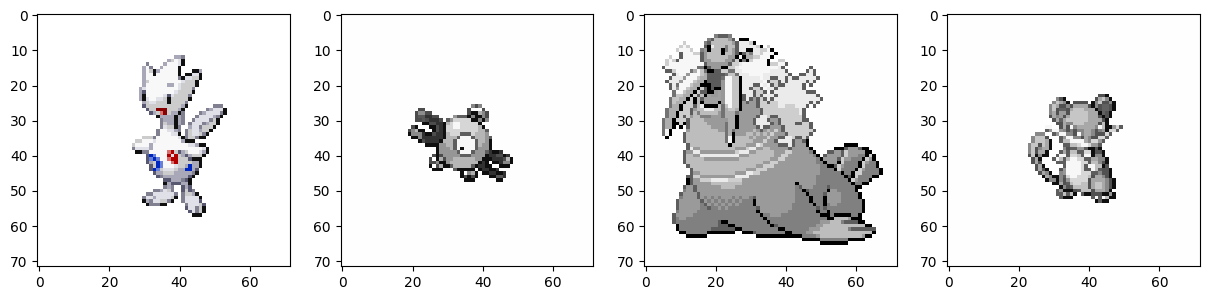

In [4]:
class Sobel():
    def __init__(self):
        self.weight = [[1, 0, -1], [0, 0, 0], [1, 0, -1]]
        self.weight = torch.tensor(self.weight, dtype=torch.float32)
        self.weight = self.weight[None, None, :, :].expand(3, -1, -1, -1)

    def __call__(self, sample):
        return nn.functional.conv2d(sample, self.weight.to(sample.device), groups=3)

pos_transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64 + 6, 64 + 6)),
    v2.Pad(1, 1.0),
    #Sobel(),

])
col_transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], .3),
    v2.RandomApply([v2.RandomChannelPermutation()], .3),
    v2.RandomGrayscale(p = .3),
])

source = torch.randint(0, 2, (4,))
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([col_transform(pos_transform(x)) for x in x0], dim=0)
print(x0.shape)


fig, axes = plt.subplots(1, 4, figsize=(15, 15))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)

In [6]:
@torch.no_grad
def generate_image():
    global model
    model.eval()

    N = 3
    
    #A = torch.tensor([300, 300, 300], device=device)
    #x0 = pimages[1, [0,151,251]]
    #x0 = torch.stack([transform(x) for x in x0], dim=0)
    #x0 = isigmoid(x0)
    #z = torch.randn_like(x0)
    #x = torch.sqrt(alpha_[A])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[A])[:, None, None, None] * z

    x = torch.randn((N, 3, 72, 72), device=device)
    
    ty = [["Grass"], ["Fire"], ["Water"]]
    ty = torch.tensor([get_index(t) for t in ty], device=device)
    c = contour[0, [0, 151, 251]]
    c = torch.stack([pos_transform(d) for d in c], dim=0)
    
    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty, c) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])

        #clear_output(wait=True)
        #fig, axes = plt.subplots(1, N, figsize=(10, 10))
        #for i in range(N):
        #    plot_image(torch.sigmoid(x-e)[i], axes[i])
        #plt.show()

    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

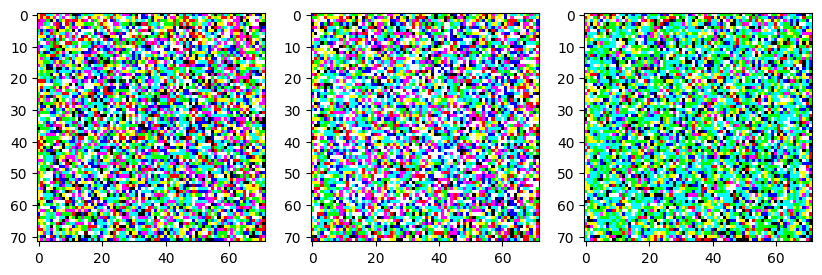

0.06549446:   1%|          | 999/100001 [00:53<1:22:51, 19.91it/s]

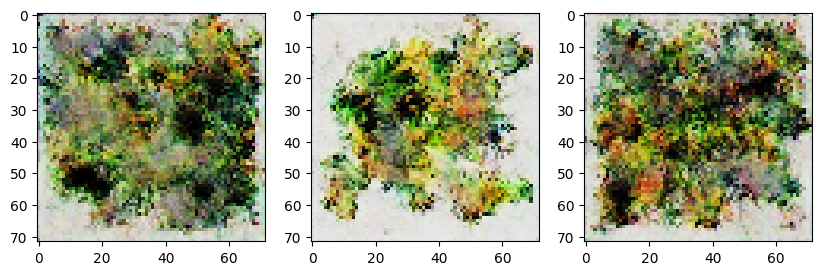

0.05468513:   2%|▏         | 1999/100001 [01:46<1:22:19, 19.84it/s] 

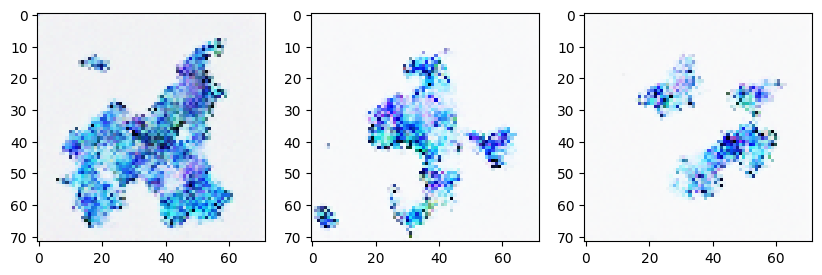

0.04754457:   3%|▎         | 2999/100001 [02:39<1:21:26, 19.85it/s] 

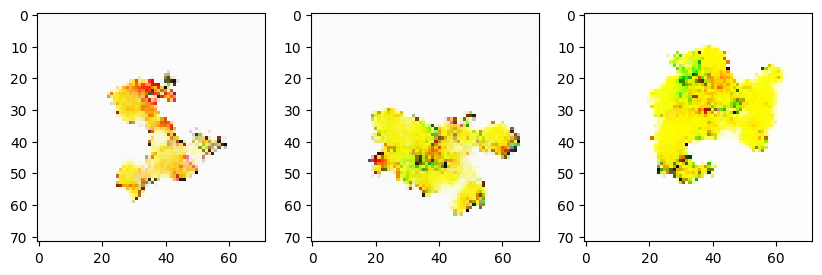

0.05706415:   4%|▍         | 4000/100001 [03:32<1:20:45, 19.81it/s] 

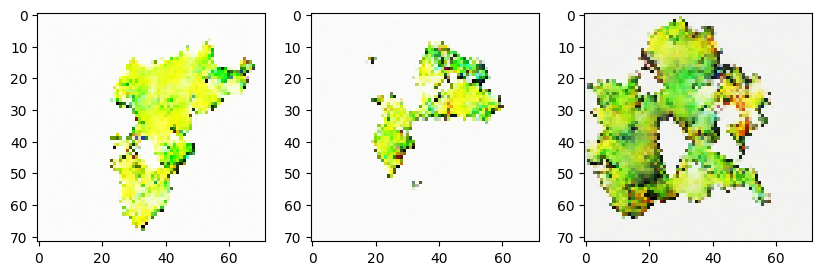

0.04164142:   5%|▍         | 5000/100001 [04:25<1:19:55, 19.81it/s] 

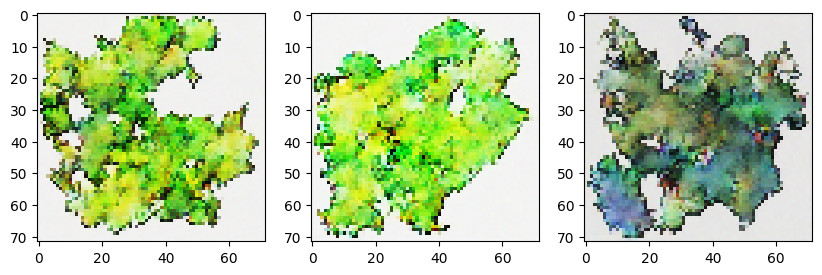

0.03864193:   6%|▌         | 6000/100001 [05:18<1:19:04, 19.81it/s] 

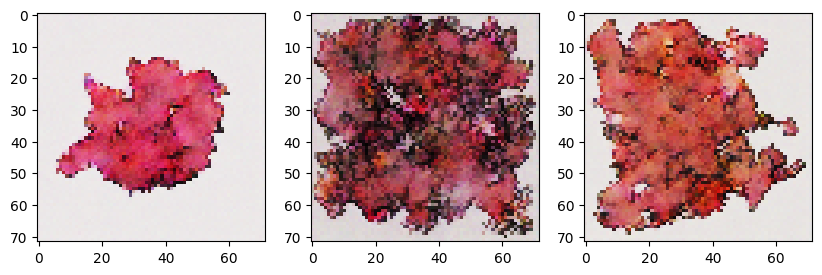

0.04923077:   7%|▋         | 7000/100001 [06:11<1:18:00, 19.87it/s] 

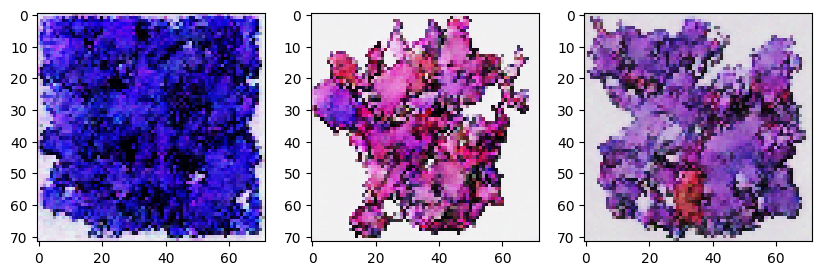

0.02919608:   8%|▊         | 8000/100001 [07:05<1:17:32, 19.77it/s] 

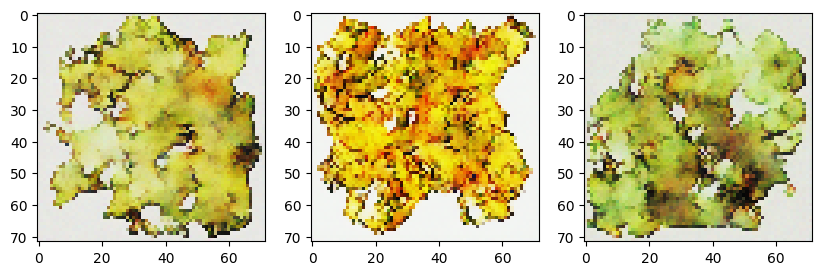

0.04833017:   9%|▉         | 8999/100001 [07:58<1:16:28, 19.83it/s] 

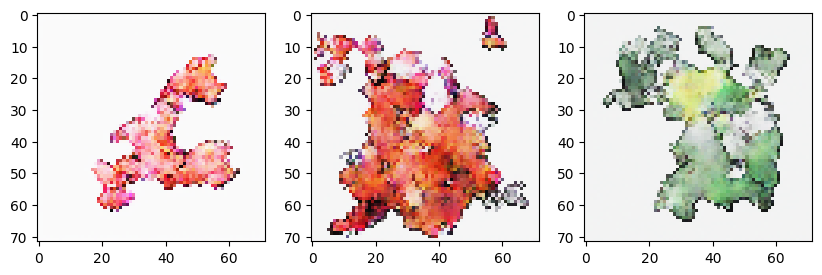

0.02041483:  10%|▉         | 10000/100001 [08:51<1:15:40, 19.82it/s]

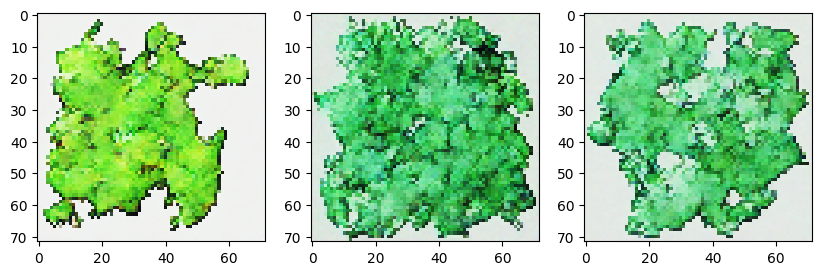

0.03099898:  11%|█         | 11000/100001 [09:44<1:14:52, 19.81it/s] 

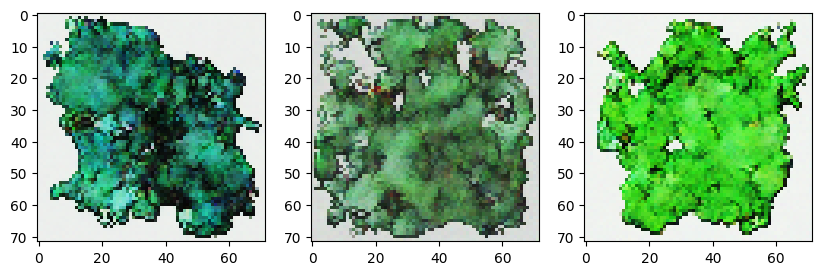

0.05395149:  12%|█▏        | 11999/100001 [10:37<1:13:58, 19.83it/s] 

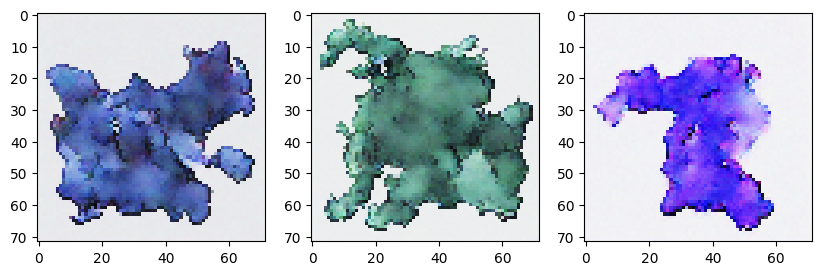

0.04398729:  13%|█▎        | 13000/100001 [11:30<1:13:08, 19.82it/s] 

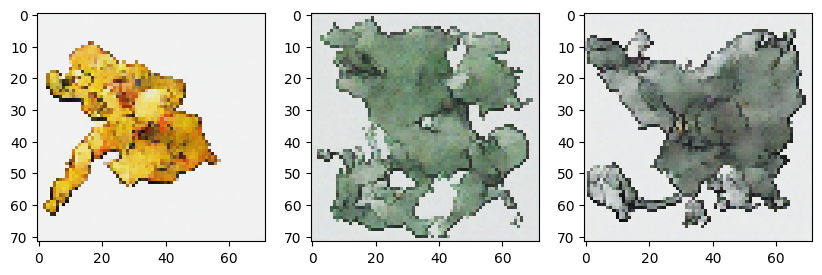

0.02884220:  14%|█▍        | 13999/100001 [12:23<1:12:17, 19.83it/s] 

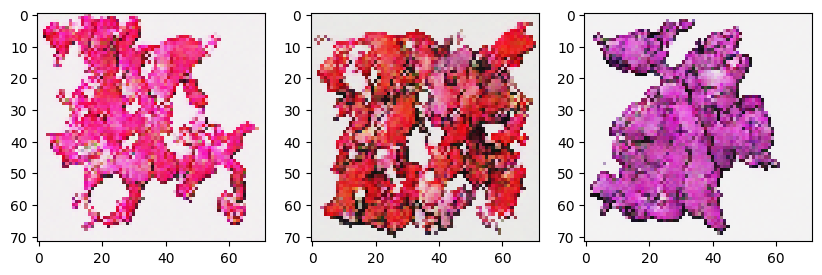

0.03748508:  15%|█▍        | 14999/100001 [13:17<1:11:24, 19.84it/s] 

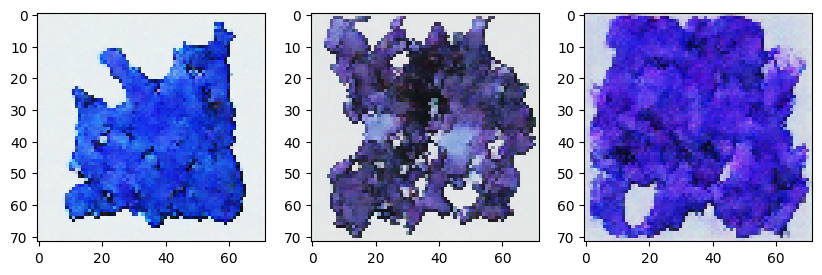

0.01840147:  16%|█▌        | 15999/100001 [14:10<1:10:20, 19.90it/s] 

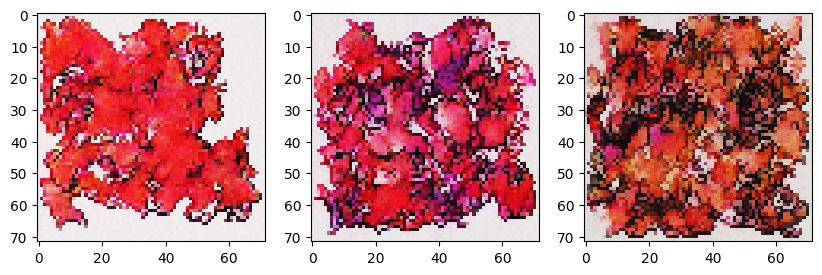

0.03642480:  17%|█▋        | 16999/100001 [15:03<1:09:47, 19.82it/s] 

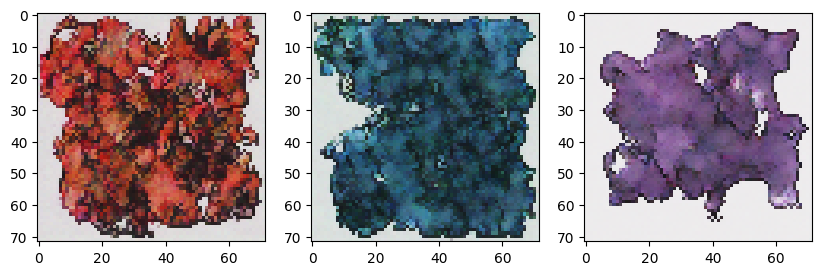

0.02877698:  18%|█▊        | 17999/100001 [15:56<1:08:59, 19.81it/s] 

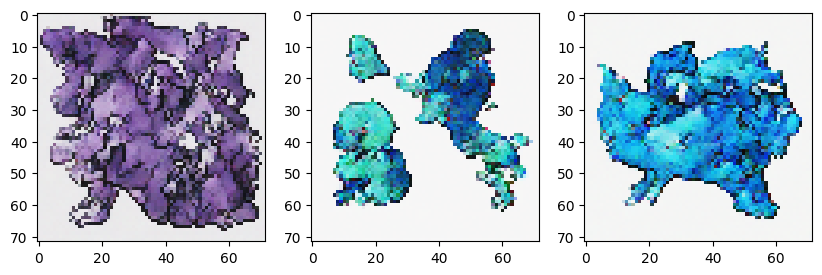

0.03779726:  19%|█▉        | 18999/100001 [16:49<1:07:59, 19.86it/s] 

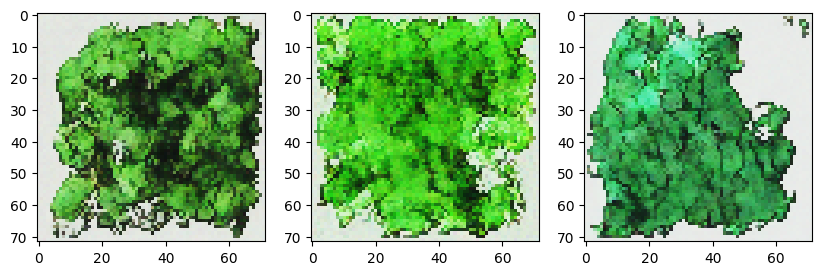

0.02641641:  20%|█▉        | 19999/100001 [17:42<1:07:13, 19.83it/s] 

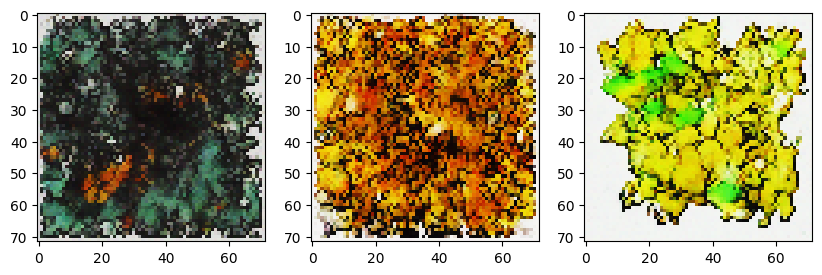

0.02632296:  21%|██        | 20999/100001 [18:35<1:06:43, 19.73it/s] 

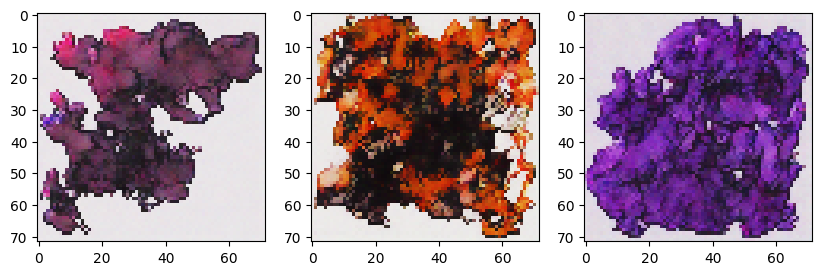

0.03328838:  22%|██▏       | 22000/100001 [19:29<1:05:34, 19.82it/s]

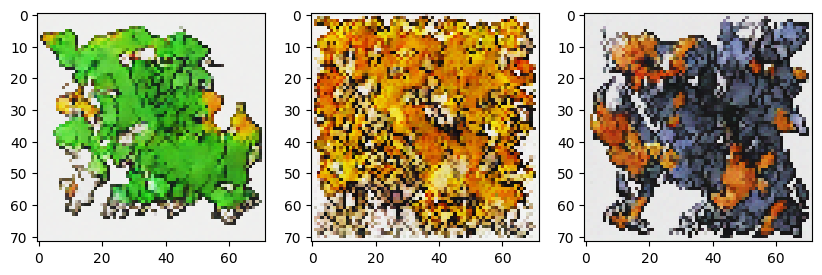

0.02314635:  23%|██▎       | 23000/100001 [20:22<1:04:49, 19.80it/s]

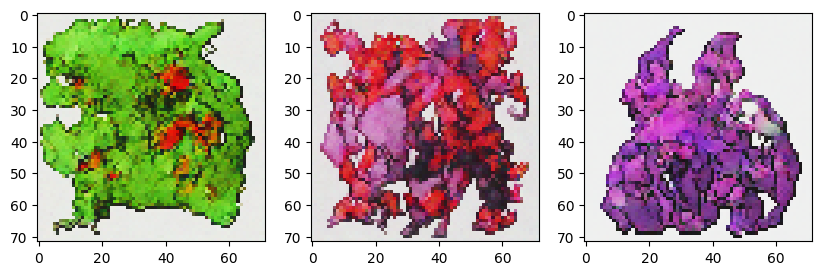

0.03010862:  24%|██▍       | 24000/100001 [21:15<1:03:56, 19.81it/s] 

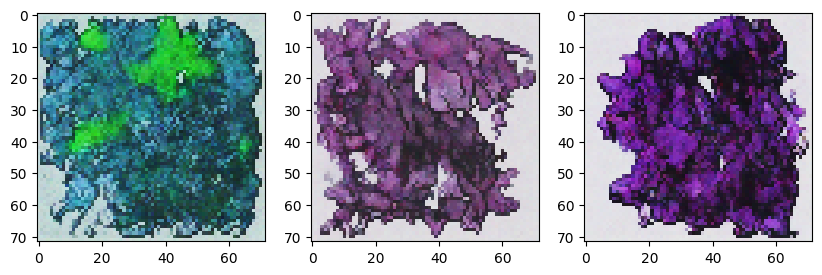

0.02035671:  25%|██▍       | 25000/100001 [22:08<1:03:12, 19.78it/s]

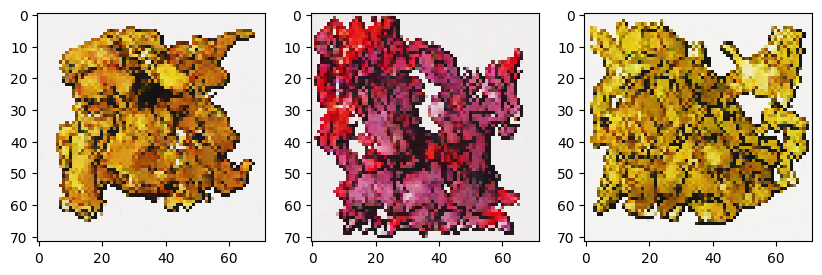

0.01999795:  26%|██▌       | 25999/100001 [23:01<1:02:12, 19.82it/s]

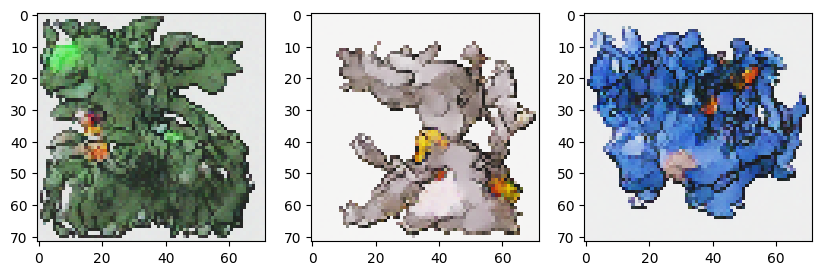

0.02758422:  27%|██▋       | 26999/100001 [23:54<1:01:19, 19.84it/s]

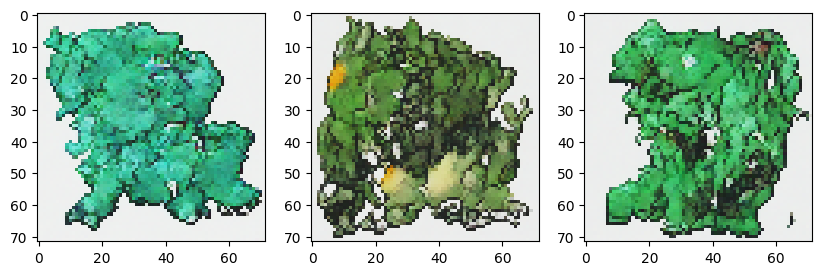

0.02254295:  28%|██▊       | 27999/100001 [24:47<1:00:27, 19.85it/s]

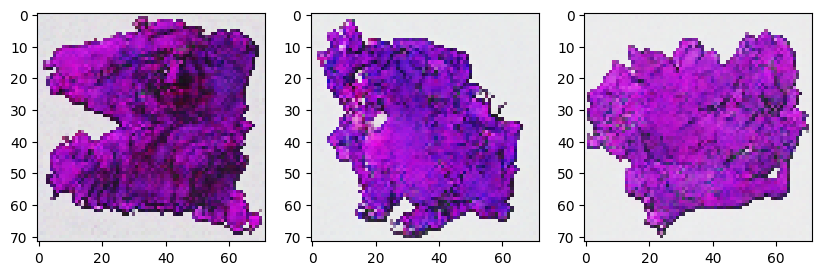

0.01675376:  29%|██▉       | 28999/100001 [25:41<59:46, 19.80it/s]  

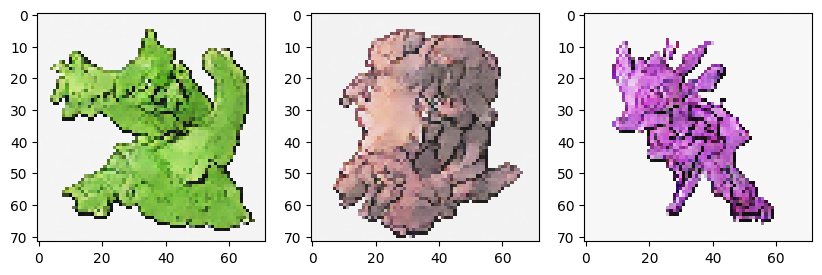

0.03632380:  30%|██▉       | 29999/100001 [26:34<58:58, 19.78it/s]  

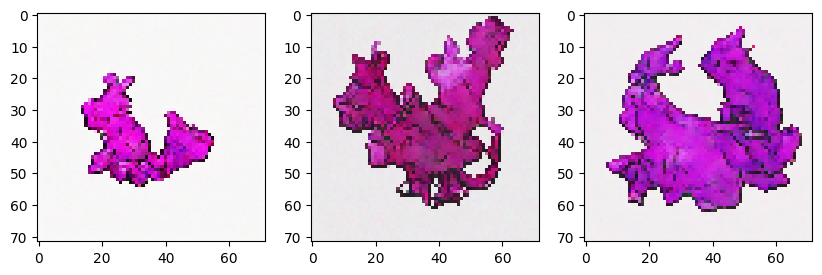

0.02590345:  31%|███       | 30999/100001 [27:27<58:07, 19.79it/s]  

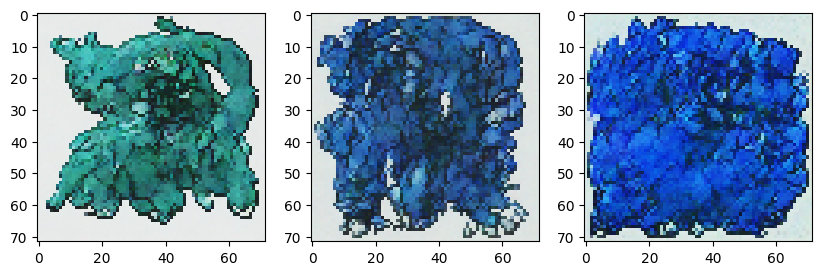

0.02460113:  32%|███▏      | 31999/100001 [28:20<57:18, 19.77it/s]  

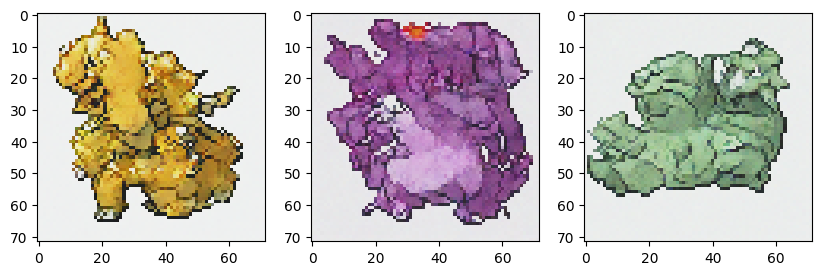

0.03030511:  33%|███▎      | 32999/100001 [29:13<56:17, 19.84it/s]  

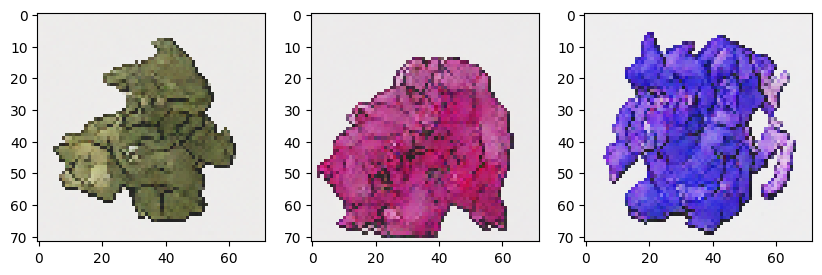

0.03329851:  34%|███▍      | 33999/100001 [30:06<55:24, 19.85it/s]  

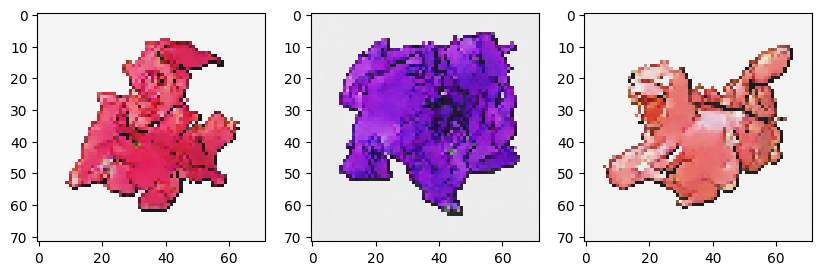

0.01242794:  35%|███▍      | 34999/100001 [31:00<54:40, 19.81it/s]  

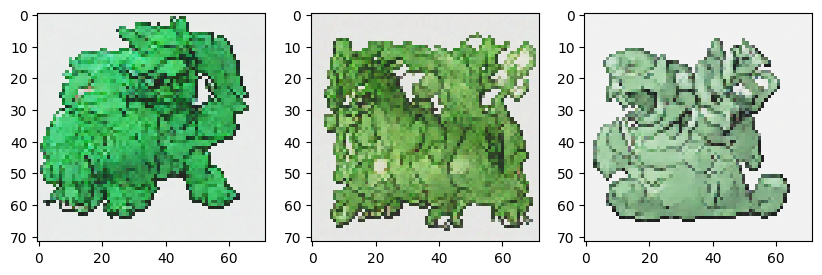

0.01152293:  36%|███▌      | 35999/100001 [31:53<53:47, 19.83it/s]  

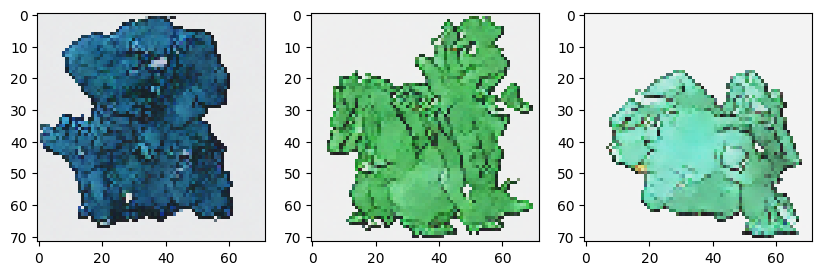

0.01297413:  37%|███▋      | 36999/100001 [32:46<52:53, 19.85it/s]  

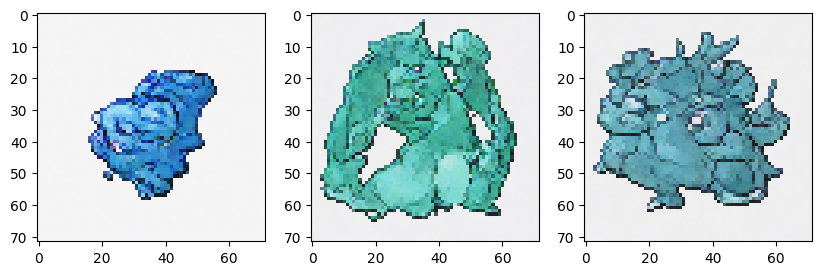

0.02857355:  38%|███▊      | 37999/100001 [33:39<52:08, 19.82it/s]  

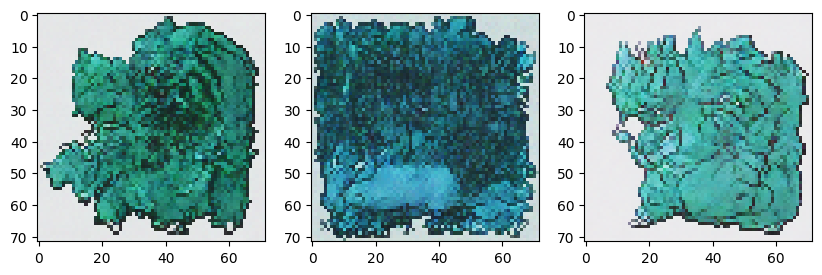

0.01837021:  39%|███▉      | 38999/100001 [34:32<51:14, 19.84it/s]  

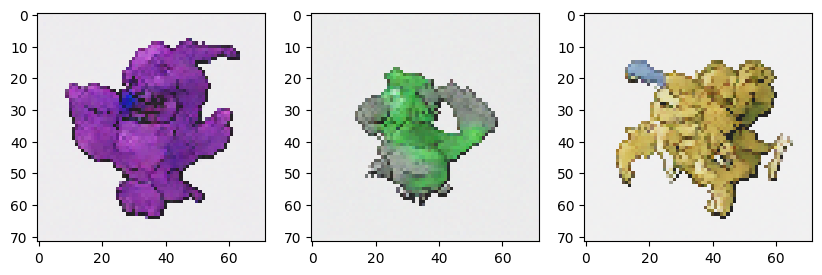

0.01287049:  40%|███▉      | 39999/100001 [35:25<50:27, 19.82it/s]  

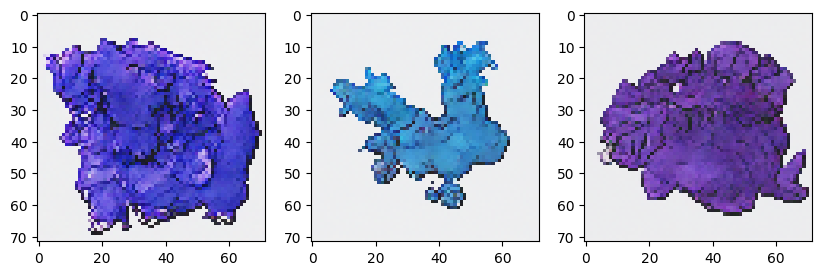

0.01640037:  41%|████      | 40999/100001 [36:18<49:40, 19.80it/s]  

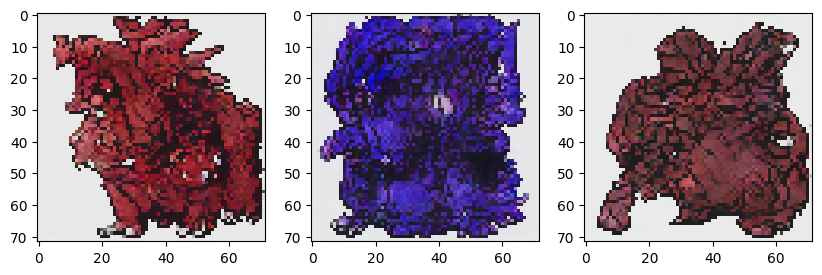

0.01435415:  42%|████▏     | 41999/100001 [37:12<48:51, 19.79it/s]  

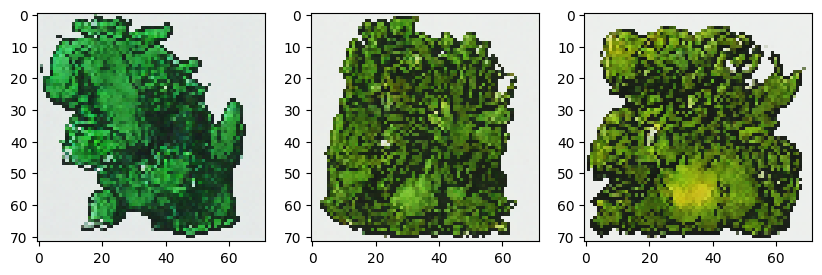

0.01570103:  43%|████▎     | 42999/100001 [38:05<47:55, 19.82it/s]  

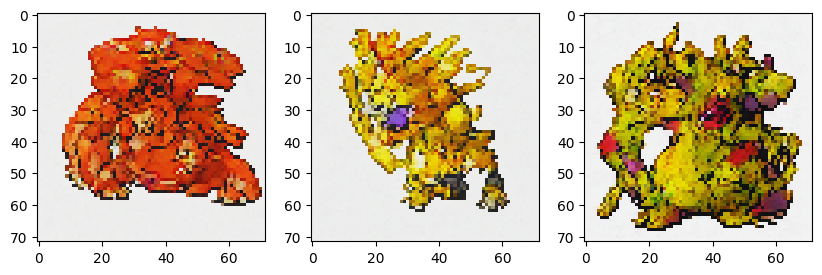

0.02203547:  44%|████▍     | 43999/100001 [38:58<47:03, 19.83it/s]  

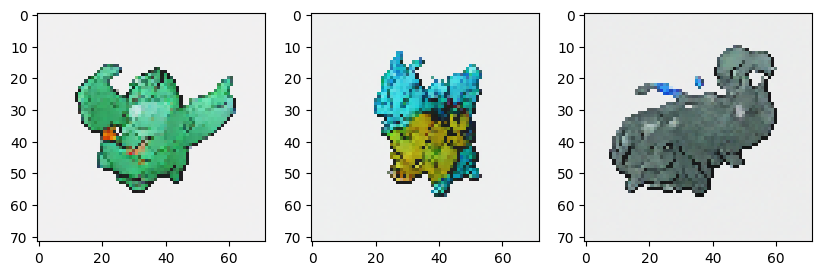

0.02441579:  45%|████▍     | 44999/100001 [39:51<46:14, 19.83it/s]  

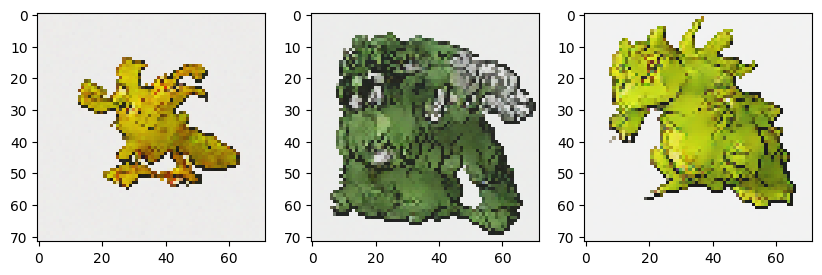

0.03808140:  46%|████▌     | 45999/100001 [40:44<45:29, 19.78it/s]  

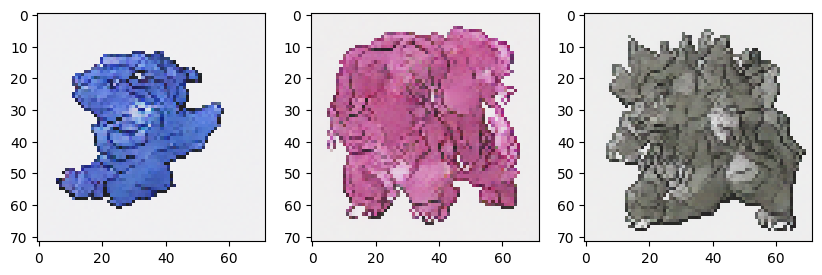

0.01325706:  47%|████▋     | 47000/100001 [41:38<44:29, 19.85it/s]  

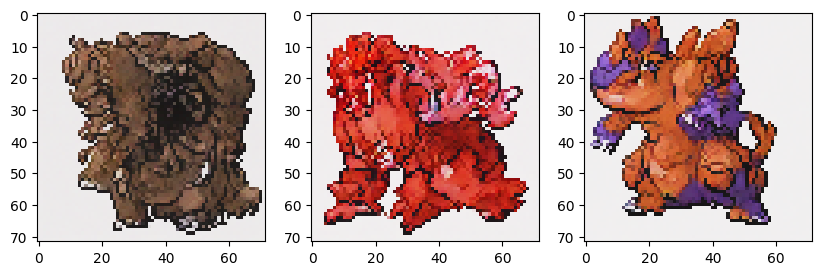

0.01501280:  48%|████▊     | 47999/100001 [42:31<43:47, 19.79it/s]  

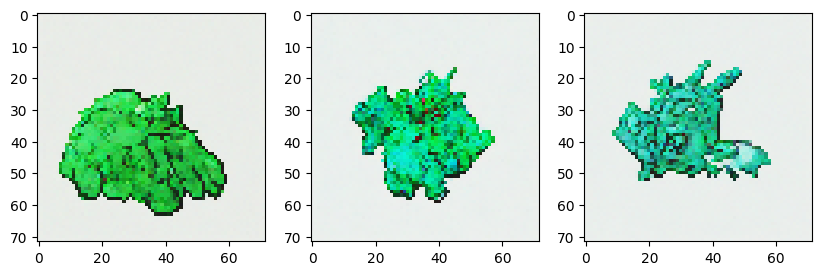

0.02991073:  49%|████▉     | 48999/100001 [43:24<42:55, 19.80it/s]  

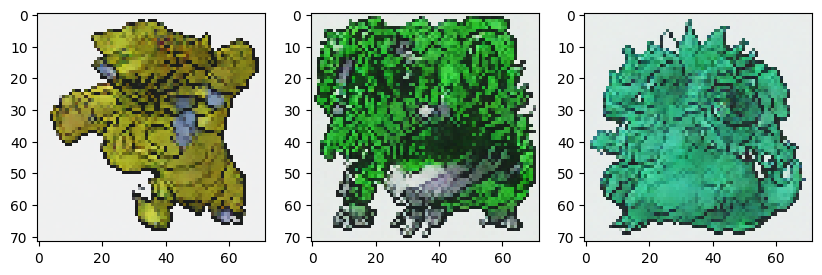

0.01907230:  50%|████▉     | 50000/100001 [44:17<42:02, 19.82it/s]  

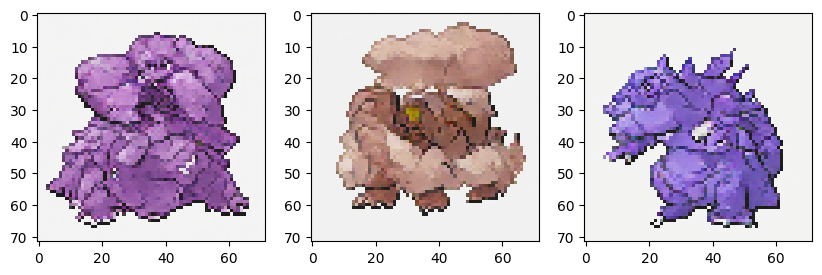

0.01639884:  51%|█████     | 51000/100001 [45:10<41:15, 19.80it/s]  

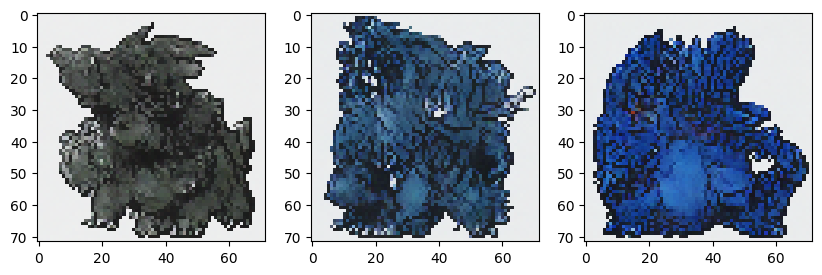

0.01913662:  52%|█████▏    | 51999/100001 [46:03<40:22, 19.82it/s]  

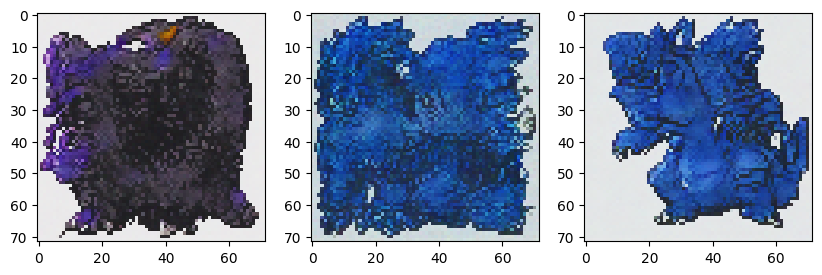

0.01777006:  53%|█████▎    | 53000/100001 [46:56<39:35, 19.79it/s]  

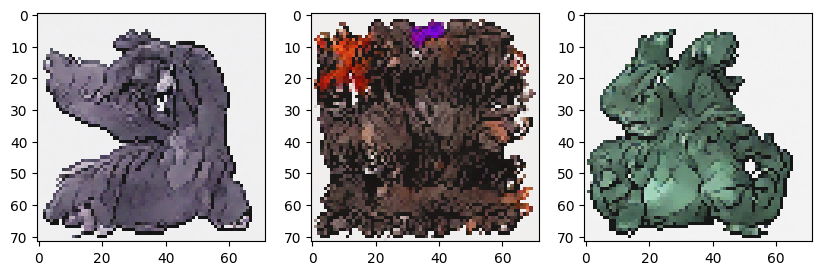

0.02476090:  54%|█████▍    | 54000/100001 [47:50<38:43, 19.80it/s]  

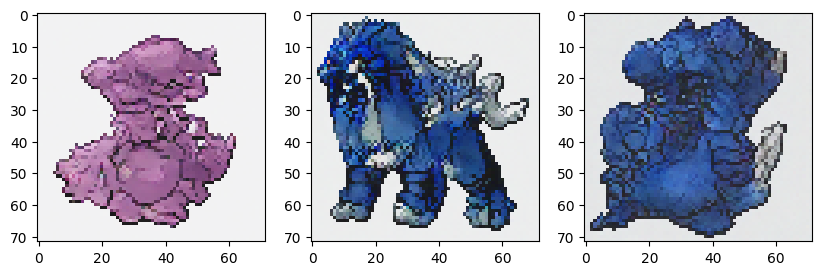

0.02877409:  55%|█████▍    | 55000/100001 [48:43<37:51, 19.81it/s]  

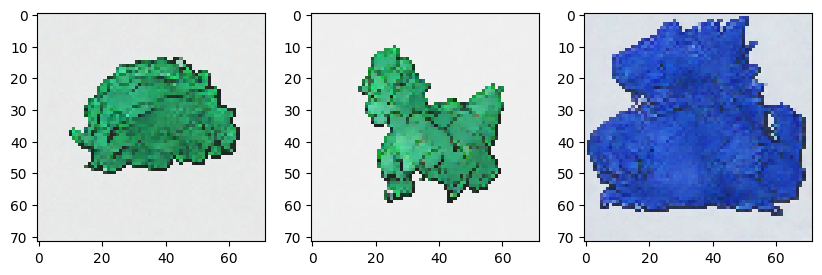

0.02085217:  56%|█████▌    | 56000/100001 [49:36<36:59, 19.82it/s]  

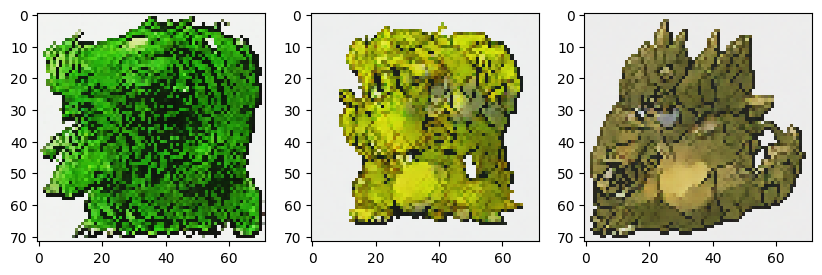

0.01938719:  57%|█████▋    | 57000/100001 [50:29<36:04, 19.86it/s]  

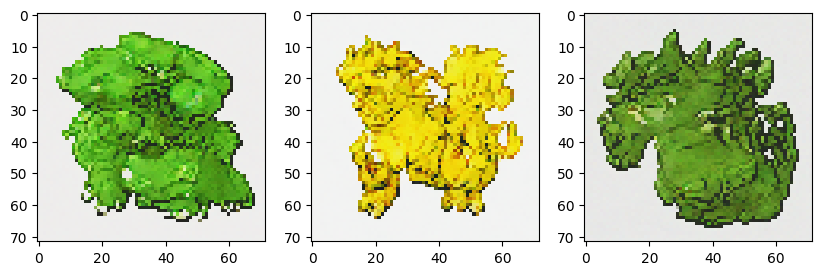

0.01870774:  58%|█████▊    | 58000/100001 [51:22<35:20, 19.81it/s]  

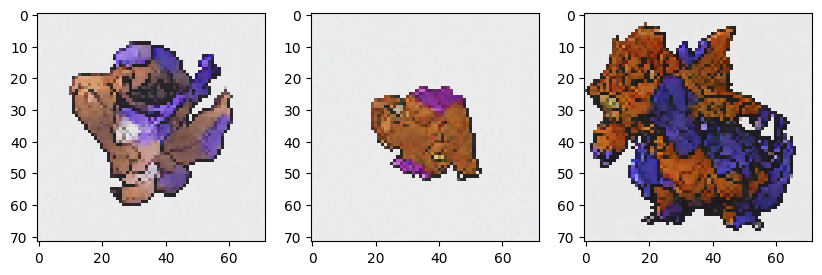

0.01923094:  59%|█████▉    | 58999/100001 [52:15<34:25, 19.85it/s]  

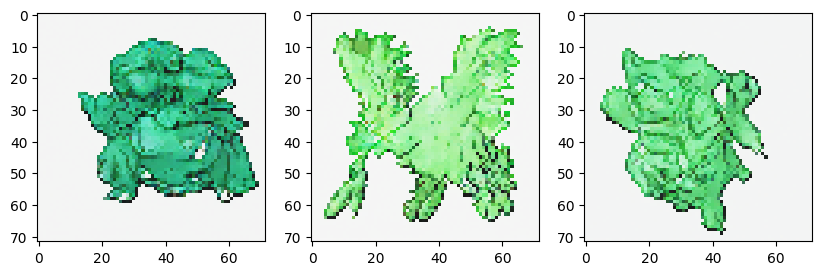

0.02122137:  60%|█████▉    | 59999/100001 [53:08<33:38, 19.82it/s]  

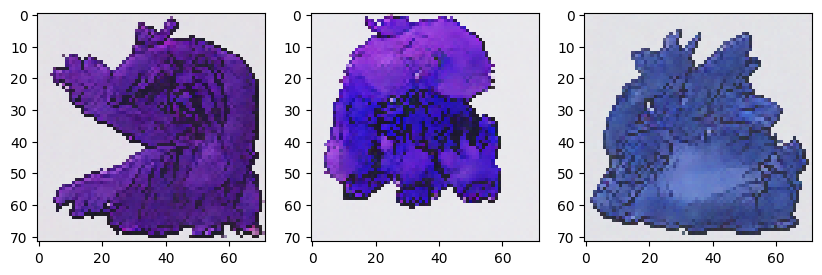

0.02211268:  61%|██████    | 60999/100001 [54:02<32:49, 19.80it/s]  

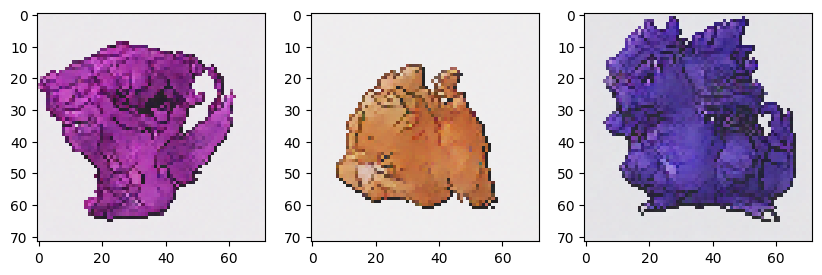

0.01538105:  62%|██████▏   | 61999/100001 [54:55<31:50, 19.89it/s]  

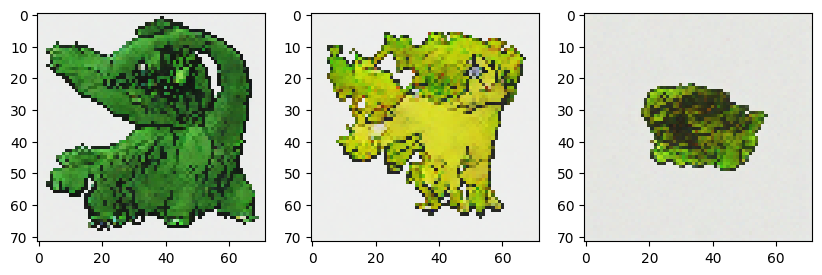

0.02001665:  63%|██████▎   | 62999/100001 [55:48<31:03, 19.86it/s]  

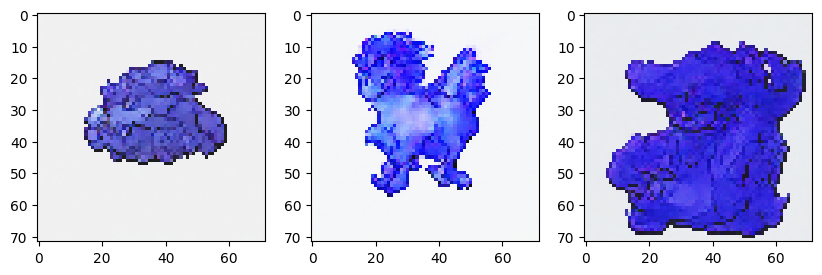

0.02941571:  64%|██████▍   | 63999/100001 [56:41<30:21, 19.76it/s]  

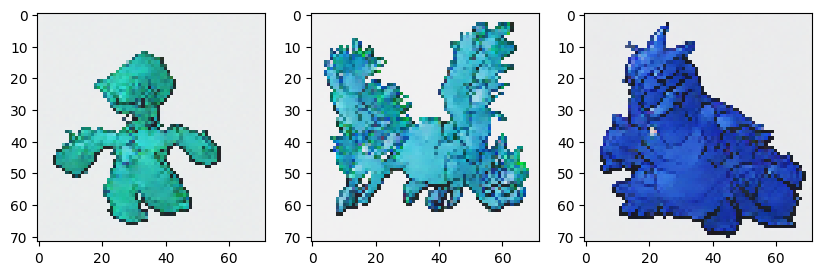

0.02159228:  65%|██████▍   | 64999/100001 [57:34<29:20, 19.88it/s]  

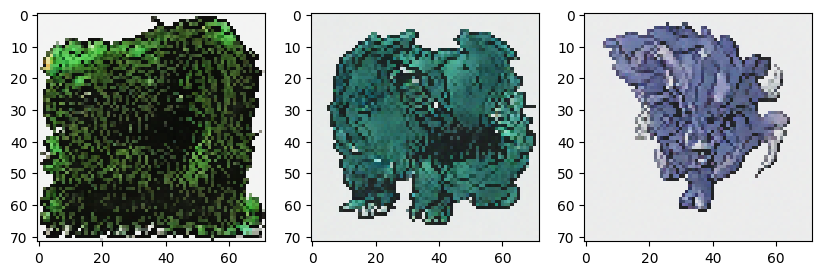

0.01138064:  66%|██████▌   | 66000/100001 [58:27<28:32, 19.86it/s]  

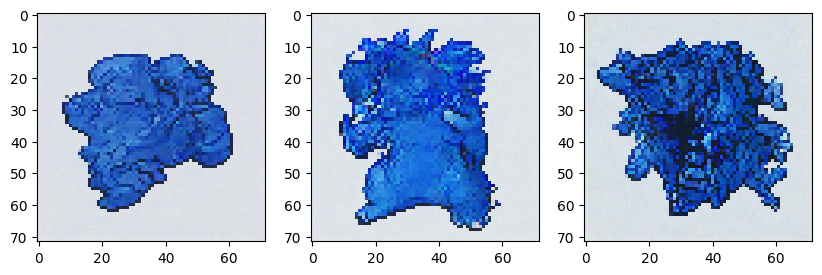

0.01711265:  67%|██████▋   | 67000/100001 [59:20<27:46, 19.80it/s]  

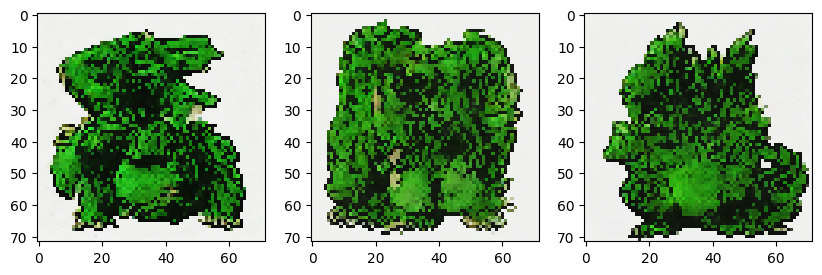

0.01464864:  68%|██████▊   | 68000/100001 [1:00:14<26:54, 19.82it/s]

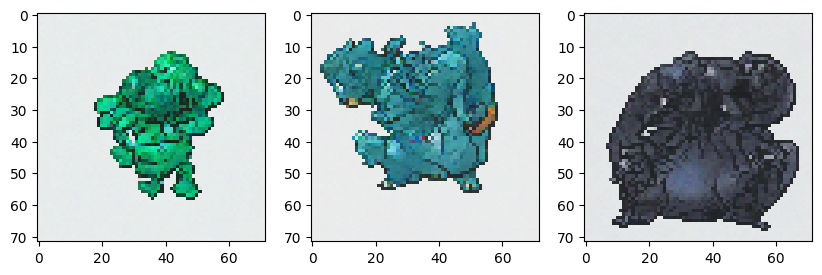

0.02940191:  69%|██████▉   | 69000/100001 [1:01:07<26:02, 19.84it/s]  

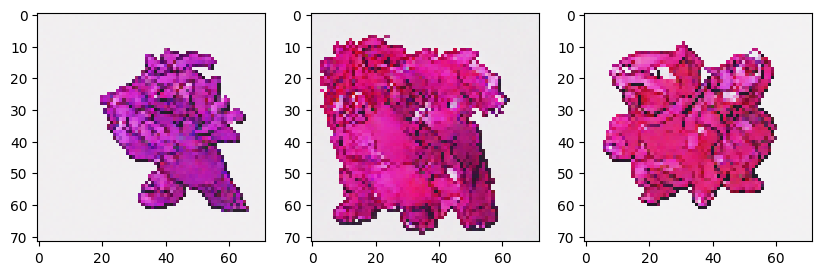

0.01930330:  70%|██████▉   | 70000/100001 [1:02:00<25:13, 19.83it/s]  

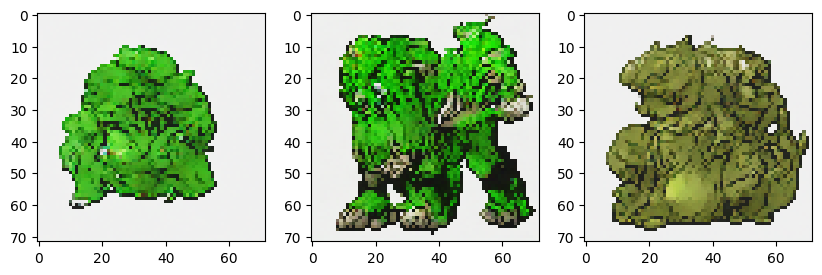

0.02833140:  71%|███████   | 71000/100001 [1:02:53<24:22, 19.84it/s]  

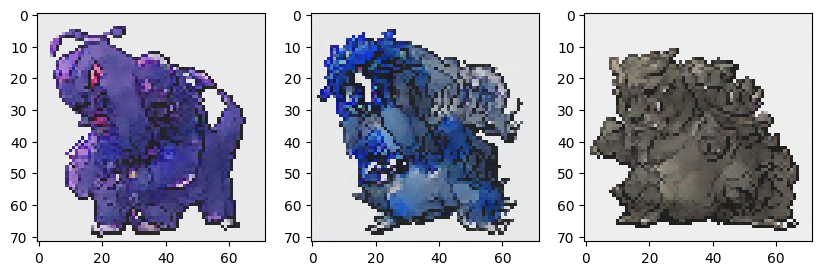

0.02266710:  72%|███████▏  | 71999/100001 [1:03:46<23:34, 19.80it/s]  

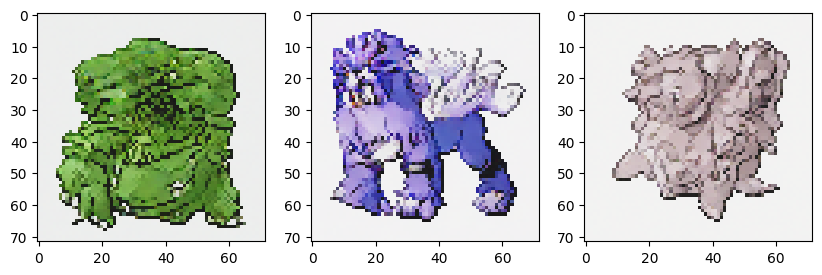

0.01449202:  73%|███████▎  | 72999/100001 [1:04:39<22:45, 19.78it/s]  

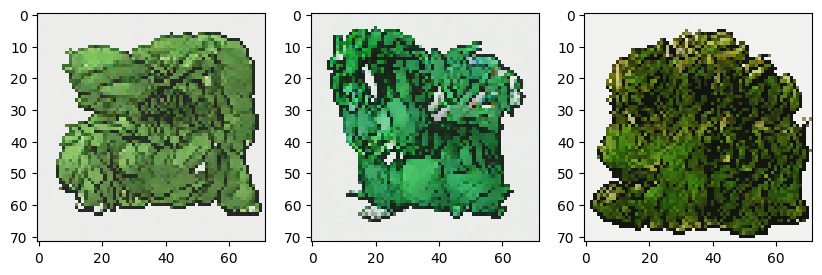

0.01624428:  74%|███████▍  | 73999/100001 [1:05:32<21:51, 19.82it/s]  

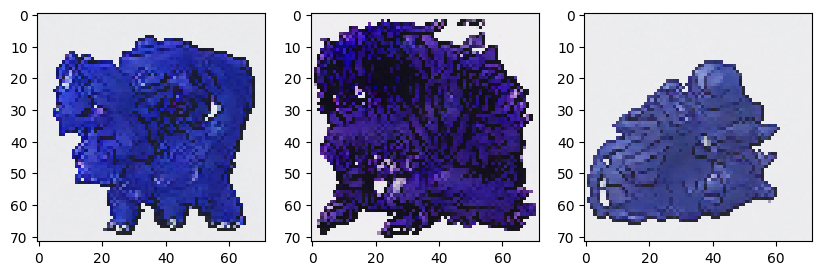

0.01232311:  75%|███████▍  | 74999/100001 [1:06:25<21:02, 19.80it/s]  

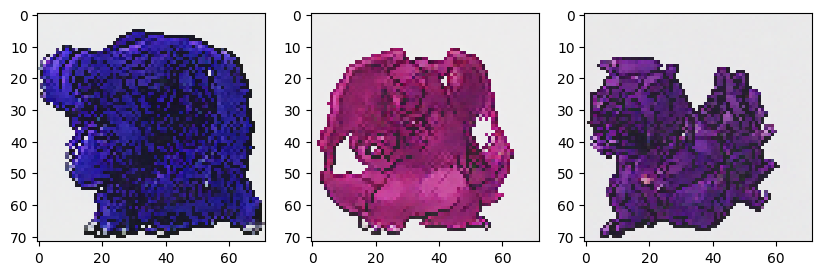

0.01658369:  76%|███████▌  | 76000/100001 [1:07:19<20:13, 19.78it/s]  

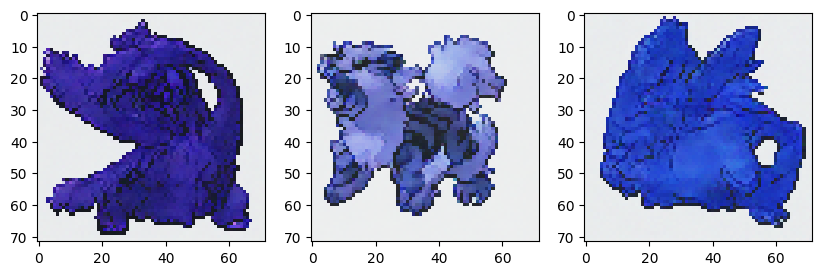

0.02017332:  77%|███████▋  | 76999/100001 [1:08:12<19:16, 19.90it/s]  

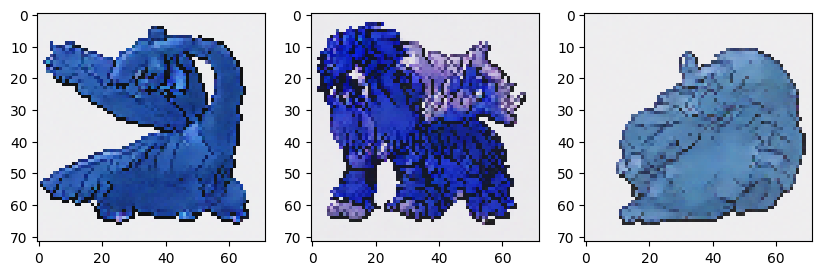

0.01145247:  78%|███████▊  | 77999/100001 [1:09:05<18:30, 19.80it/s]  

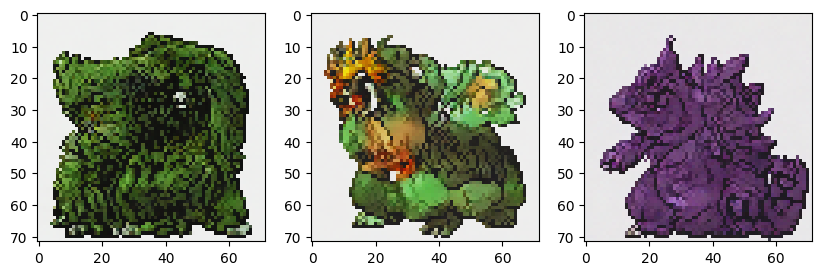

0.01960572:  79%|███████▉  | 78999/100001 [1:09:58<17:37, 19.85it/s]  

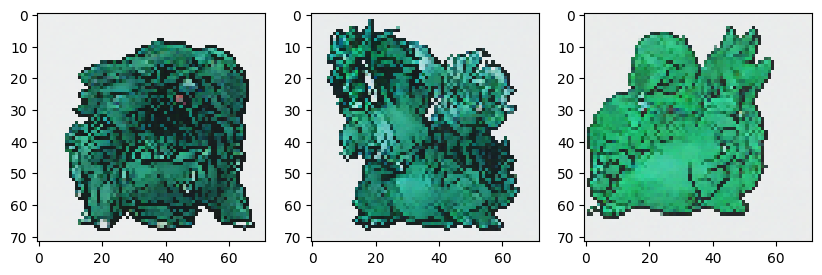

0.02487551:  80%|███████▉  | 79999/100001 [1:10:51<16:48, 19.83it/s]  

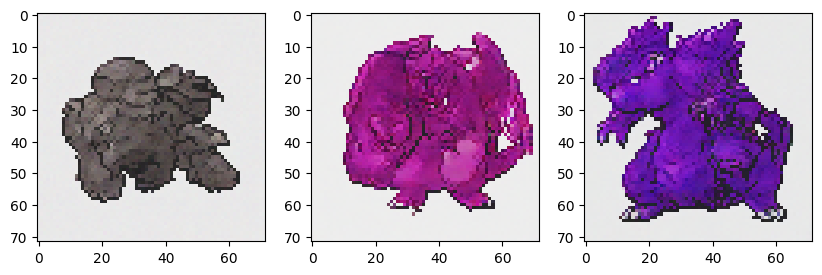

0.01915527:  81%|████████  | 80999/100001 [1:11:44<15:59, 19.81it/s]  

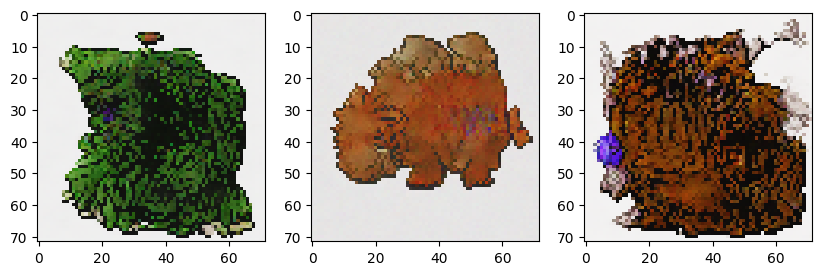

0.01243537:  82%|████████▏ | 81999/100001 [1:12:38<15:09, 19.80it/s]  

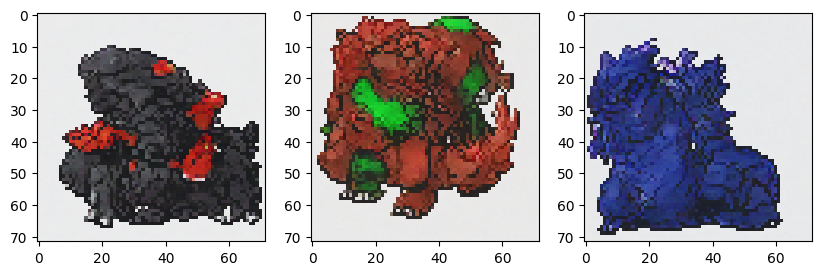

0.01089571:  83%|████████▎ | 82999/100001 [1:13:31<14:20, 19.77it/s]  

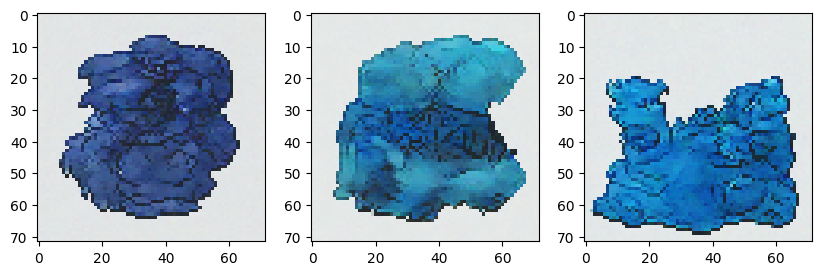

0.02486797:  84%|████████▍ | 83999/100001 [1:14:24<13:27, 19.82it/s]  

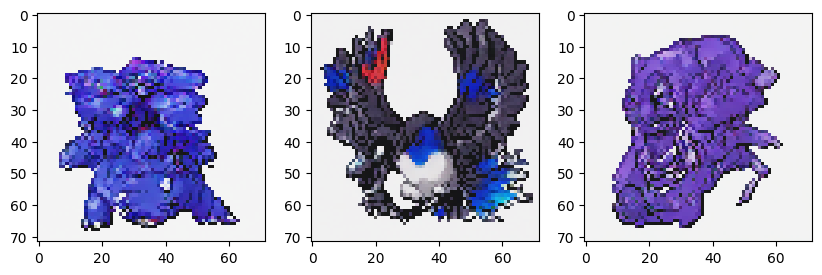

0.02289796:  85%|████████▍ | 84999/100001 [1:15:17<12:37, 19.81it/s]  

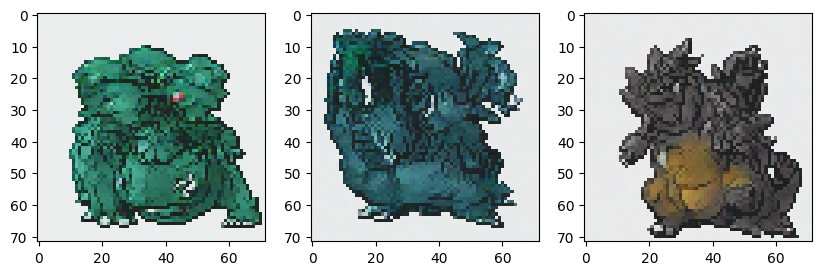

0.02500912:  86%|████████▌ | 85999/100001 [1:16:10<11:47, 19.80it/s]  

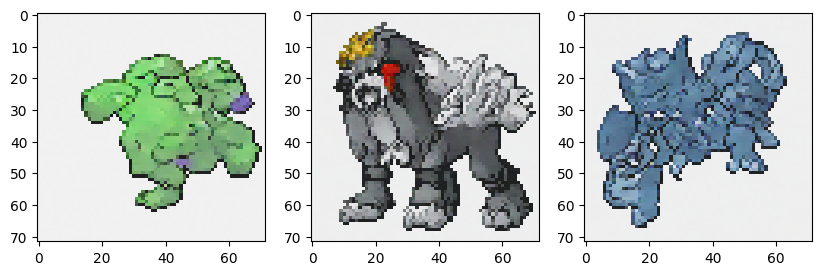

0.01342256:  87%|████████▋ | 86999/100001 [1:17:03<10:54, 19.85it/s]  

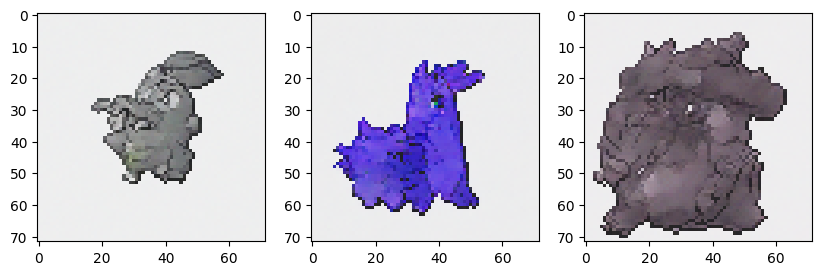

0.01759752:  88%|████████▊ | 87999/100001 [1:17:56<10:04, 19.84it/s]  

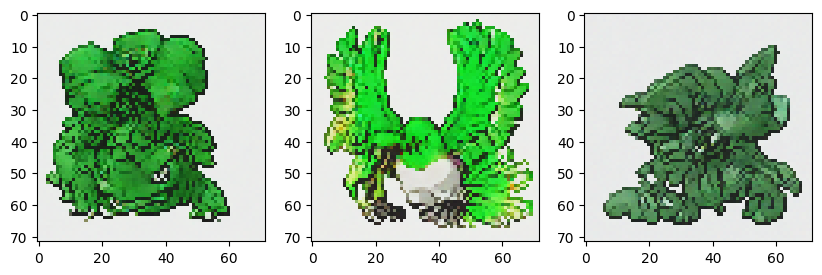

0.01194230:  89%|████████▉ | 88999/100001 [1:18:50<09:15, 19.81it/s]  

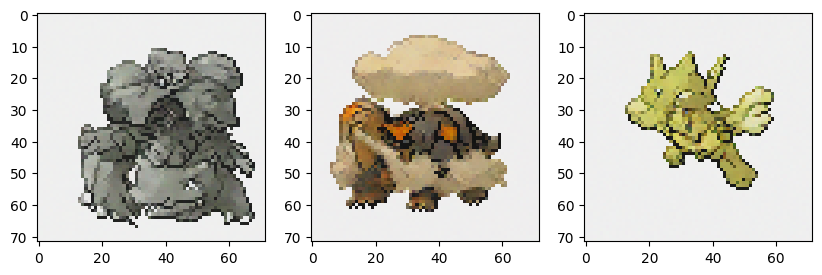

0.01681987:  90%|████████▉ | 90000/100001 [1:19:43<08:24, 19.81it/s]  

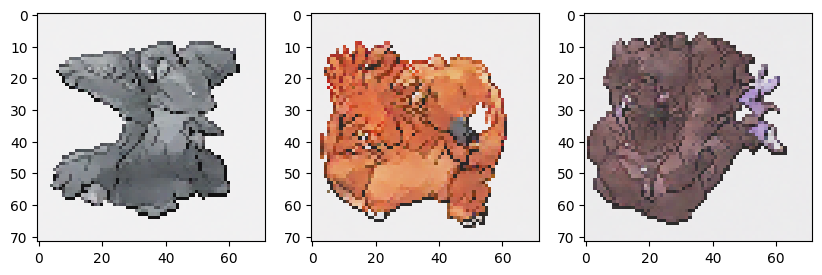

0.01645960:  91%|█████████ | 91000/100001 [1:20:36<07:34, 19.79it/s]  

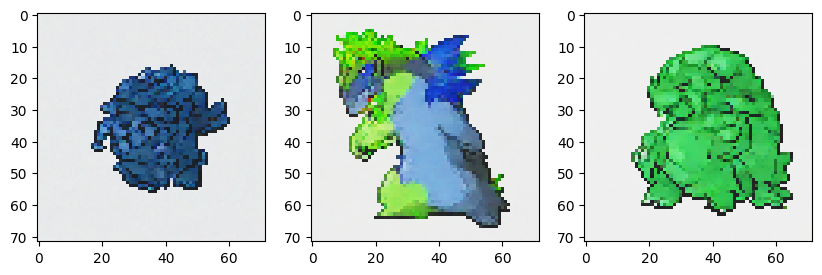

0.02010262:  92%|█████████▏| 92000/100001 [1:21:29<06:43, 19.81it/s]  

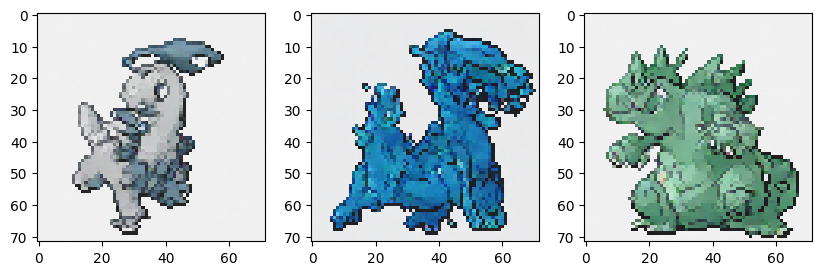

0.01774158:  93%|█████████▎| 92999/100001 [1:22:22<05:53, 19.83it/s]  

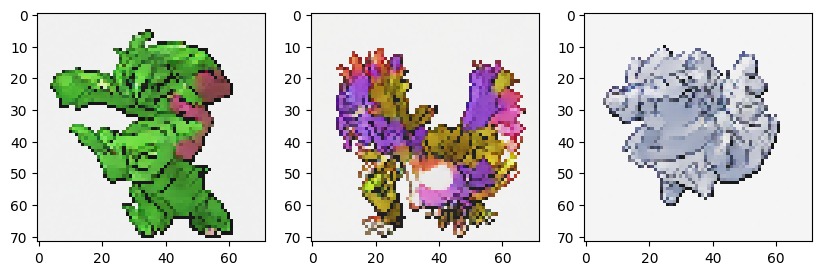

0.00900509:  94%|█████████▍| 93999/100001 [1:23:15<05:03, 19.80it/s]

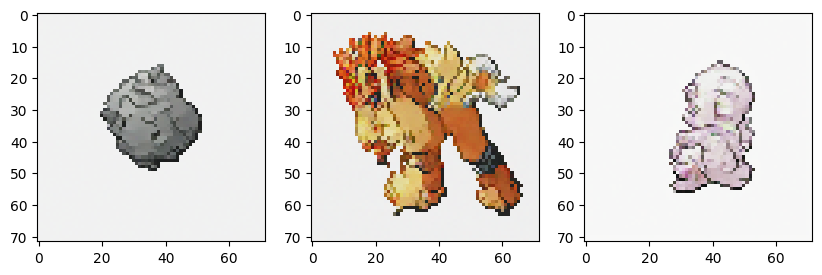

0.01560206:  95%|█████████▍| 94999/100001 [1:24:09<04:12, 19.79it/s]

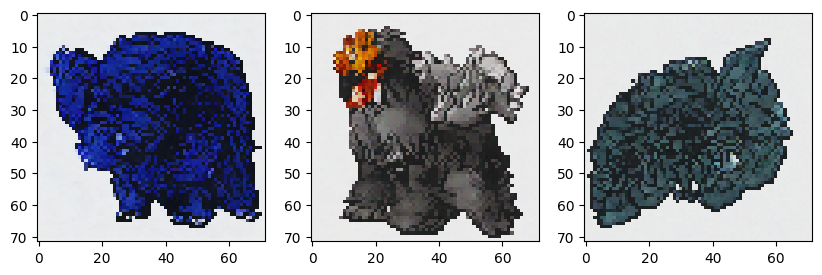

0.01049309:  96%|█████████▌| 95999/100001 [1:25:02<03:22, 19.79it/s]

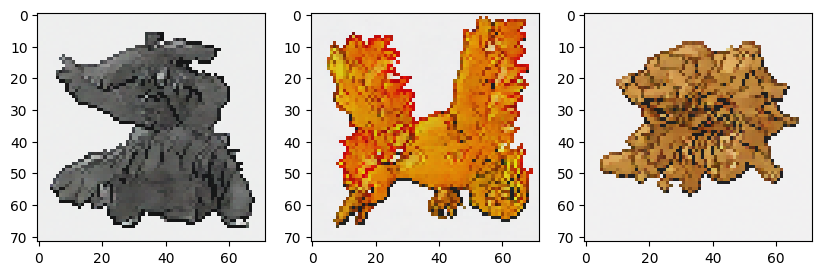

0.01636707:  97%|█████████▋| 96999/100001 [1:25:55<02:31, 19.82it/s]

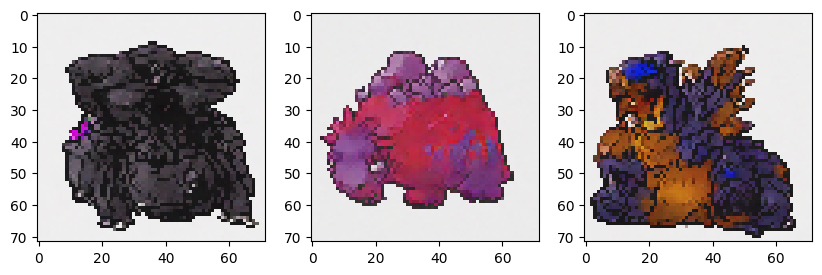

0.02390844:  98%|█████████▊| 98000/100001 [1:26:48<01:40, 19.83it/s]

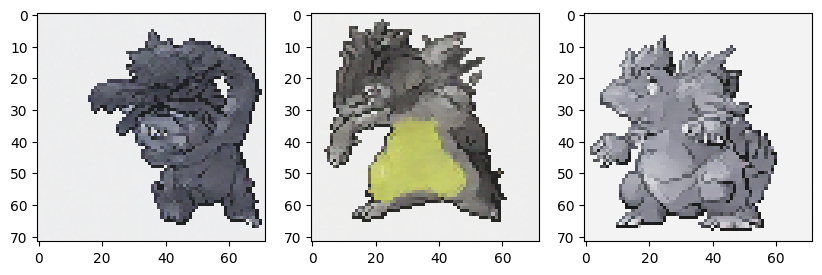

0.01625996:  99%|█████████▉| 98999/100001 [1:27:41<00:50, 19.81it/s]

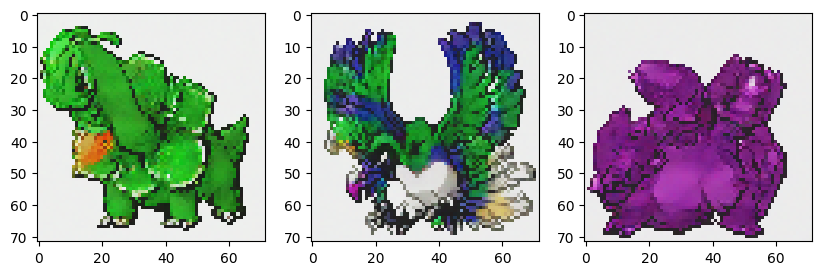

0.02506062: 100%|█████████▉| 99999/100001 [1:28:34<00:00, 19.83it/s]

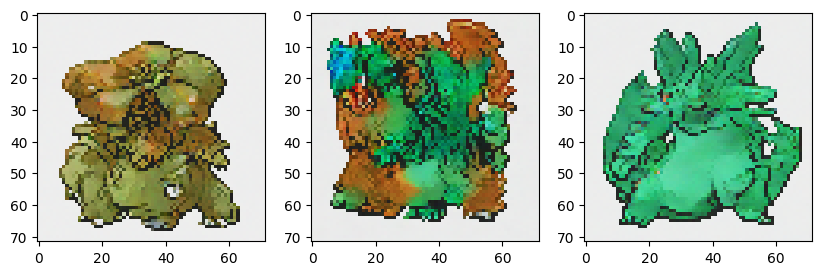

0.02104484: 100%|██████████| 100001/100001 [1:28:37<00:00, 18.81it/s]


In [8]:
model = UNet(3, 3, time_dim=256, num_classes=len(all_types) + 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

loss_func = nn.MSELoss()

pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 16

    source = torch.randint(0, 2, (bs,))
    batch = torch.randperm(385)[:bs]
    
    x0 = pimages[source, batch]
    c = contour[source, batch]

    xc = torch.cat([x0, c], dim=1)
    xc = torch.stack([pos_transform(x) for x in xc], dim=0)
    
    x0 = xc[:, :-1]
    c = xc[:, [-1]]

    x0 = torch.stack([col_transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    ty = types[batch]

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty, c)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')